***
<center><img src='https://github.com/HesamAsad/HesamAsad.github.io/blob/main/images/LOGO_EN_blue.png?raw=true' width=250/></center>

# <center>
## <center><span style='font-family:"Times New Roman"'><span style='background:dark'>  <font color='#1966ab'>$\LARGE{\text{Sharif University of Technology}}$</font>  <br>  <br>  <font color='#FFFFCC'>$\Large{\text{Masoud Tahmasbi}}$ </font> <br> <font color='#FFFFCC'>$\normalsize {\text{Student ID: } 402200275}$ </font>  <br>  <br> <font color='#33FFCC'>$\large{\text{CE957: Reinforcement Learning}}$</font> <br>  <font color='#FFFF00'>$\normalsize{\text{Assignment #4 - Offline RL, Behavioral Cloning}}$ </font>
<br>

***




In this notebook, we will implement the Soft Actor Critic (SAC) algorithm on the CartPole environment in both online and offline settings. The SAC framework focuses on maximizing the expected reward while also maximizing entropy, meaning the actor aims to succeed at the task while maintaining a high level of randomness in its actions. This approach explicitly encourages exploration by seeking a high entropy in the policy.

In the second part, we will use the policy learned in the first part to collect a dataset of expert trajectories and perform behavioral cloning.

*The existing results are the baseline for the quality of your implementation.*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## Network Structure (10 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [ ]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO
        # Define your network layers
        ##########################################################
        self.output_activation = output_activation
        self.layer_stack_1 = nn.Sequential(
        nn.Linear(in_features=input_dimension, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=output_dimension)
        )

    def forward(self, input):
        ##########################################################
        # TODO
        # Calculate the output
        ##########################################################
        return self.output_activation(self.layer_stack_1(input))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Replay Buffer

A SAC agent requires a replay buffer to sample previously visited states. You can utilize the implemented code below to set up this replay buffer.

In [ ]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=5000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 1e-2
        self.delta = 1e-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

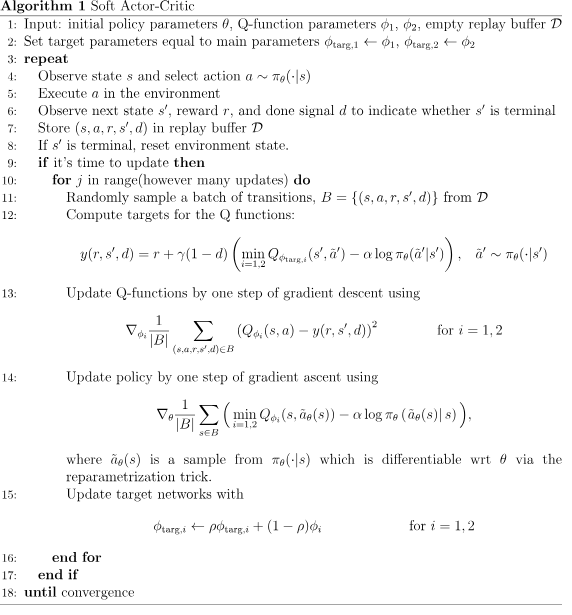

In [ ]:
class SACAgent:
    def __init__(self, environment, replay_buffer=None, offline=False, learning_rate=1e-4,
                 discount=0.99, buffer_batch_size=100, alpha_init=1, interpolation_factor=0.01):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.alpha_init = alpha_init
        self.learning_rate = learning_rate
        self.discount = discount
        self.buffer_batch_size = buffer_batch_size
        self.interpolation_factor = interpolation_factor

        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.offline = offline

        ##########################################################
        # TODO
        # Define critics usig your implemented feed forward netwrok
        ##########################################################
        self.critic_local = Network(input_dimension=self.state_dim,
                            output_dimension=self.action_dim)

        self.critic_local2 = Network(input_dimension=self.state_dim,
                            output_dimension=self.action_dim)

        self.critic_optimizer = torch.optim.Adam(self.critic_local.parameters(),
                                                 lr=self.learning_rate)

        self.critic_optimizer2 = torch.optim.Adam(self.critic_local2.parameters(),
                                                 lr=self.learning_rate)

        self.critic_target = Network(input_dimension=self.state_dim,
                            output_dimension=self.action_dim)

        self.critic_target2 = Network(input_dimension=self.state_dim,
                            output_dimension=self.action_dim)

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        # TODO
        # Define the actor
        # Define the actor optimizer
        ##########################################################
        self.actor_local = Network(input_dimension=self.state_dim,
                            output_dimension=self.action_dim,
                            output_activation=nn.Softmax(dim=1))

        self.actor_optimizer  = torch.optim.Adam(self.actor_local.parameters(),
                                                 lr=self.learning_rate)

        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.alpha_init), requires_grad=True)

        self.alpha = self.log_alpha
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=self.learning_rate)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO
        # You are going to calculate critic losses in this method
        ##########################################################
        with torch.no_grad():
            action_probabilities, log_action_probabilities = self.get_action_info(next_states_tensor)
            q_values_target = self.critic_target(next_states_tensor)
            q_values_target2 = self.critic_target2(next_states_tensor)

            soft_q_values = (action_probabilities * (
                        torch.min(q_values_target, q_values_target2) - self.alpha * log_action_probabilities)).sum(dim=1)

            q_targets = rewards_tensor + self.discount * soft_q_values * (~done_tensor)

        q_estimated1  = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
        q_estimated2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)

        critic1_MSEloss = nn.MSELoss(reduction="none")(q_estimated1, q_targets)
        critic2_MSEloss = nn.MSELoss(reduction="none")(q_estimated2, q_targets)

        prediction_errors = [min(loss1.item(), loss2.item()) for loss1, loss2 in zip(critic1_MSEloss, critic2_MSEloss)]
        self.replay_buffer.update_weights(prediction_errors)
        critic1_loss = critic1_MSEloss.mean()
        critic2_loss = critic2_MSEloss.mean()

        return critic1_loss, critic2_loss

    def actor_loss(self, states_tensor, actions_tensor):
        ##########################################################
        # TODO
        # Implement the actor loss
        ##########################################################
        q_estimated1  = self.critic_local(states_tensor)
        q_estimated2 = self.critic_local2(states_tensor)

        action_probabilities, log_action_probabilities = self.get_action_info(states_tensor)
        actor_loss = (action_probabilities * (
                    self.alpha * log_action_probabilities - torch.min(q_estimated1, q_estimated2))).sum(dim=1).mean()

        return actor_loss, log_action_probabilities

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO
        # Set all the gradients stored in the optimizers to zero
        # Add the new transition to the replay buffer for online case
        ##########################################################

        self.actor_optimizer.zero_grad()
        self.alpha_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        self.critic_optimizer2.zero_grad()

        if not self.offline:
            self.replay_buffer.add_transition(transition)

        if self.replay_buffer.get_size() >= self.buffer_batch_size:
            minibatch = self.replay_buffer.sample_minibatch(self.buffer_batch_size,
                                                            batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            ##########################################################
            # TODO
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it
            # You also need to update \alpha
            ##########################################################
            critic1_loss, critic2_loss = self.critic_loss(states_tensor,
                                                          actions_tensor, rewards_tensor,next_states_tensor, done_tensor)
            critic1_loss.backward()
            self.critic_optimizer.step()

            critic2_loss.backward()
            self.critic_optimizer2.step()

            actor_loss, log_action_probabilities = self.actor_loss(states_tensor, actions_tensor)
            actor_loss.backward()
            self.actor_optimizer.step()


            alpha_loss = self.temperature_loss(log_action_probabilities)
            alpha_loss.backward()
            self.alpha_optimizer.step()
            self.alpha = self.log_alpha.exp()

            self.soft_update_target_networks(self.interpolation_factor)

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state, action):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

In [ ]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 1500
STEPS_PER_EPISODE = 200
RUNS = 1
REPORT_PER_EPISODE = 100
env = gym.make("CartPole-v1")
online_replay_buffer = ReplayBuffer(env, capacity=1500000)

##########################################################
# TODO
# Implement the training loop for the online SAC.
# After each epoch, run validation
# and plot the mean return over these
# episodes in the end
# Plot the learning curves
##########################################################
agents_reward = []

for run in range(RUNS):
    online_agent = SACAgent(env)
    runs_reward = []

    for episode in range(EPISODES_PER_RUN):
        if episode % REPORT_PER_EPISODE == 0:
            print(f'Episode {episode+1} of Run {run+1}')

        done = False
        episode_reward = 0
        evaluation_episode = episode % TRAINING_EVALUATION_RATIO == 0
        state = env.reset()
        step = 0
        while not done and step < STEPS_PER_EPISODE:
            action = online_agent.get_next_action(state, evaluation_episode)
            next_state, reward, done, _ = env.step(action)

            transition = (state, action, reward, next_state, done)
            online_replay_buffer.add_transition(transition)

            if evaluation_episode:
                episode_reward += reward
            else:
                online_agent.train_on_transition(state, action, next_state, reward, done)

            state = next_state
            step += 1
        if evaluation_episode:
            runs_reward.append(episode_reward)
    print(f'<--------------------------End of Run {run+1}-------------------------->')
    agents_reward.append(runs_reward)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1 of Run 1


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 101 of Run 1
Episode 201 of Run 1
Episode 301 of Run 1
Episode 401 of Run 1
Episode 501 of Run 1
Episode 601 of Run 1
Episode 701 of Run 1
Episode 801 of Run 1
Episode 901 of Run 1
<--------------------------End of Run 1-------------------------->
Episode 1 of Run 2
Episode 101 of Run 2
Episode 201 of Run 2
Episode 301 of Run 2
Episode 401 of Run 2
Episode 501 of Run 2
Episode 601 of Run 2
Episode 701 of Run 2
Episode 801 of Run 2
Episode 901 of Run 2
<--------------------------End of Run 2-------------------------->
Episode 1 of Run 3
Episode 101 of Run 3
Episode 201 of Run 3
Episode 301 of Run 3
Episode 401 of Run 3
Episode 501 of Run 3
Episode 601 of Run 3
Episode 701 of Run 3
Episode 801 of Run 3
Episode 901 of Run 3
<--------------------------End of Run 3-------------------------->
Episode 1 of Run 4
Episode 101 of Run 4
Episode 201 of Run 4
Episode 301 of Run 4
Episode 401 of Run 4
Episode 501 of Run 4
Episode 601 of Run 4
Episode 701 of Run 4
Episode 801 of Run 4
Episode

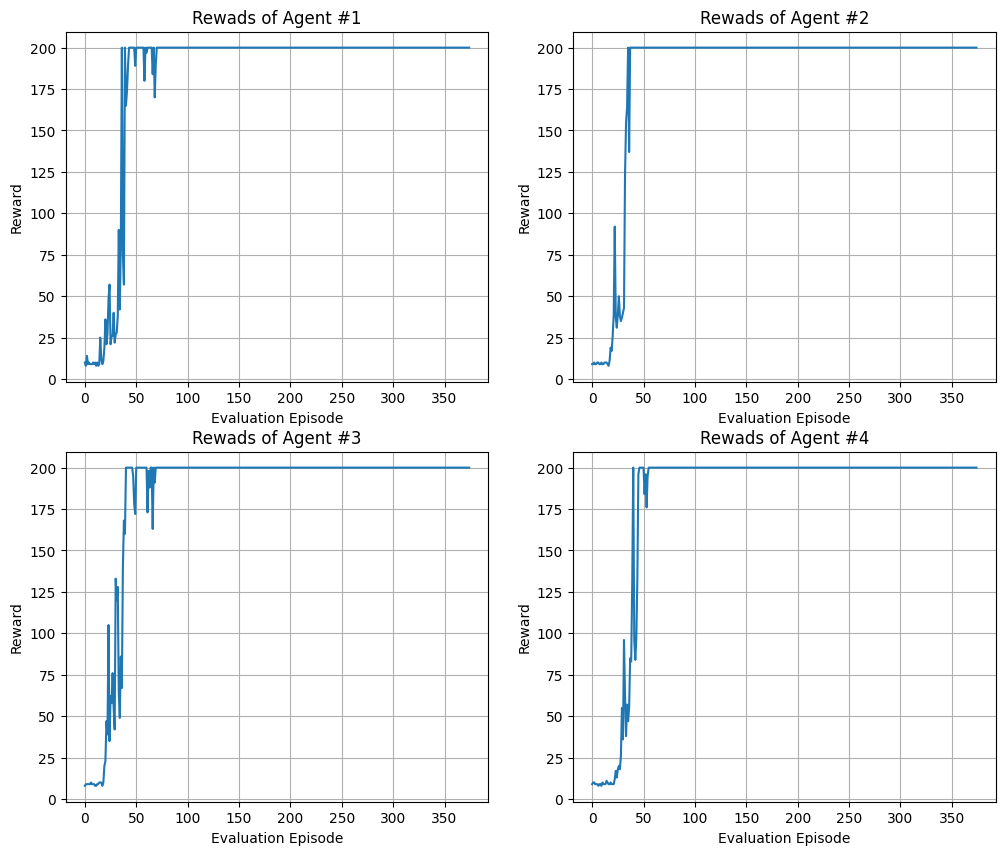

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0,0].plot(agents_reward[0])
axs[0,0].set_title('Rewads of Agent #1')
axs[0,0].set_xlabel('Evaluation Episode')
axs[0,0].set_ylabel('Reward')
axs[0,0].grid()

axs[0,1].plot(agents_reward[1])
axs[0,1].set_title('Rewads of Agent #2')
axs[0,1].set_xlabel('Evaluation Episode')
axs[0,1].set_ylabel('Reward')
axs[0,1].grid()

axs[1,0].plot(agents_reward[2])
axs[1,0].set_title('Rewads of Agent #3')
axs[1,0].set_xlabel('Evaluation Episode')
axs[1,0].set_ylabel('Reward')
axs[1,0].grid()

axs[1,1].plot(agents_reward[3])
axs[1,1].set_title('Rewads of Agent #4')
axs[1,1].set_xlabel('Evaluation Episode')
axs[1,1].set_ylabel('Reward')
axs[1,1].grid()

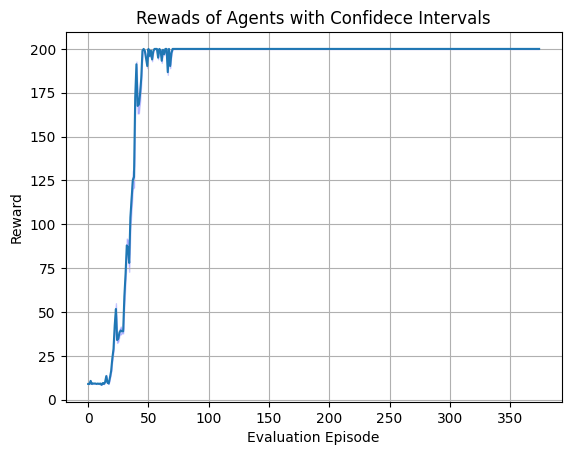

In [ ]:
confidence_interval = 1.96 * np.std(agents_reward,axis=0)/np.sqrt(np.size(agents_reward,axis=1))

mean_baseline = np.mean(agents_reward,axis=0)
fig, ax = plt.subplots()
x = range(len(mean_baseline))
ax.plot(x,mean_baseline)
ax.fill_between(x, (mean_baseline-confidence_interval), (mean_baseline+confidence_interval), color='b', alpha=.2)

ax.set_title('Rewads of Agents with Confidece Intervals')
ax.set_xlabel('Evaluation Episode')
ax.set_ylabel('Reward')
ax.grid()

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

rewards = 0
state = env.reset()
for _ in range(200):
    frames.append(env.render()[0])
    action = online_agent.get_next_action(state, evaluation_episode=False)
    state, reward, done, info = env.step(action)
    rewards += reward
    if done:
        break
print(rewards)
env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


200.0


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# saving the replay buffer
# with open("online_replay_buffer", "wb") as fp:   #Pickling
#     pickle.dump(online_replay_buffer, fp)
# !cp online_replay_buffer /content/gdrive/MyDrive

## Offline SAC (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !cp /content/gdrive/MyDrive/online_replay_buffer /content/online_replay_buffer

In [ ]:
# import pickle
# with open("online_replay_buffer", "rb") as fp:   # Unpickling
#     online_replay_buffer = pickle.load(fp)

In [ ]:
NUM_EPOCHS = 10000
STEPS_PER_EPISODE = 200
TRAINING_EVALUATION_RATIO = 100
env = gym.make("CartPole-v1")

##########################################################
# TODO
# Implement the training loop for the offline SAC.
# After each epoch, run  validation
# and plot the mean return over these
# episodes in the end
##########################################################
offline_agent = SACAgent(env,buffer_batch_size=128,learning_rate=1e-4,
                         replay_buffer=online_replay_buffer,offline=True)

epochs_reward = []
for epoch in tqdm(range(NUM_EPOCHS)):
    offline_agent.train_networks()

    evaluation_episode = epoch % TRAINING_EVALUATION_RATIO == 0

    if evaluation_episode:
        done = False
        episode_reward = 0
        state = env.reset()
        step = 0
        while not done and step < STEPS_PER_EPISODE:
            action = offline_agent.get_next_action(state, evaluation_episode=True)
            next_state, reward, done, _ = env.step(action)

            episode_reward += reward
            state = next_state
            step += 1
        print(f'\nEpisode Reward: {episode_reward}')
        epochs_reward.append(episode_reward)


  0%|          | 1/10000 [00:00<1:15:53,  2.20it/s]


Episode Reward: 10.0


  1%|          | 101/10000 [00:30<46:24,  3.56it/s]


Episode Reward: 10.0


  2%|▏         | 201/10000 [00:59<42:51,  3.81it/s]


Episode Reward: 10.0


  3%|▎         | 301/10000 [01:28<41:58,  3.85it/s]


Episode Reward: 10.0


  4%|▍         | 401/10000 [01:57<41:03,  3.90it/s]


Episode Reward: 9.0


  5%|▌         | 501/10000 [02:26<52:11,  3.03it/s]


Episode Reward: 9.0


  6%|▌         | 601/10000 [03:04<45:02,  3.48it/s]


Episode Reward: 10.0


  7%|▋         | 701/10000 [03:41<48:51,  3.17it/s]


Episode Reward: 13.0


  8%|▊         | 801/10000 [04:19<46:00,  3.33it/s]


Episode Reward: 10.0


  9%|▉         | 901/10000 [04:57<53:59,  2.81it/s]


Episode Reward: 17.0


 10%|█         | 1001/10000 [05:35<42:25,  3.54it/s]


Episode Reward: 21.0


 11%|█         | 1101/10000 [06:04<39:25,  3.76it/s]


Episode Reward: 22.0


 12%|█▏        | 1201/10000 [06:34<38:46,  3.78it/s]


Episode Reward: 18.0


 13%|█▎        | 1301/10000 [07:03<39:09,  3.70it/s]


Episode Reward: 33.0


 14%|█▍        | 1401/10000 [07:33<49:35,  2.89it/s]


Episode Reward: 35.0


 15%|█▌        | 1501/10000 [08:03<53:07,  2.67it/s]


Episode Reward: 47.0


 16%|█▌        | 1601/10000 [08:33<38:36,  3.63it/s]


Episode Reward: 36.0


 17%|█▋        | 1701/10000 [09:03<37:55,  3.65it/s]


Episode Reward: 38.0


 18%|█▊        | 1801/10000 [09:33<37:24,  3.65it/s]


Episode Reward: 45.0


 19%|█▉        | 1901/10000 [10:03<39:32,  3.41it/s]


Episode Reward: 36.0


 20%|██        | 2001/10000 [10:34<49:48,  2.68it/s]


Episode Reward: 34.0


 21%|██        | 2101/10000 [11:03<36:22,  3.62it/s]


Episode Reward: 28.0


 22%|██▏       | 2201/10000 [11:33<34:45,  3.74it/s]


Episode Reward: 54.0


 23%|██▎       | 2301/10000 [12:03<34:16,  3.74it/s]


Episode Reward: 32.0


 24%|██▍       | 2401/10000 [12:32<33:16,  3.81it/s]


Episode Reward: 52.0


 25%|██▌       | 2501/10000 [13:03<53:21,  2.34it/s]


Episode Reward: 30.0


 26%|██▌       | 2601/10000 [13:33<34:30,  3.57it/s]


Episode Reward: 64.0


 27%|██▋       | 2701/10000 [14:03<33:20,  3.65it/s]


Episode Reward: 134.0


 28%|██▊       | 2801/10000 [14:32<33:16,  3.61it/s]


Episode Reward: 79.0


 29%|██▉       | 2901/10000 [15:02<32:04,  3.69it/s]


Episode Reward: 61.0


 30%|███       | 3001/10000 [15:33<45:05,  2.59it/s]


Episode Reward: 46.0


 31%|███       | 3101/10000 [16:03<31:40,  3.63it/s]


Episode Reward: 46.0


 32%|███▏      | 3201/10000 [16:32<30:35,  3.70it/s]


Episode Reward: 44.0


 33%|███▎      | 3301/10000 [17:02<29:57,  3.73it/s]


Episode Reward: 34.0


 34%|███▍      | 3401/10000 [17:32<29:46,  3.69it/s]


Episode Reward: 27.0


 35%|███▌      | 3501/10000 [18:03<47:56,  2.26it/s]


Episode Reward: 50.0


 36%|███▌      | 3601/10000 [18:32<29:27,  3.62it/s]


Episode Reward: 38.0


 37%|███▋      | 3701/10000 [19:02<29:05,  3.61it/s]


Episode Reward: 108.0


 38%|███▊      | 3801/10000 [19:31<27:53,  3.70it/s]


Episode Reward: 68.0


 39%|███▉      | 3901/10000 [20:01<27:04,  3.75it/s]


Episode Reward: 88.0


 40%|████      | 4001/10000 [20:32<43:33,  2.30it/s]


Episode Reward: 36.0


 41%|████      | 4101/10000 [21:02<27:37,  3.56it/s]


Episode Reward: 53.0


 42%|████▏     | 4201/10000 [21:31<26:38,  3.63it/s]


Episode Reward: 39.0


 43%|████▎     | 4301/10000 [22:01<25:44,  3.69it/s]


Episode Reward: 75.0


 44%|████▍     | 4401/10000 [22:31<25:25,  3.67it/s]


Episode Reward: 56.0


 45%|████▌     | 4501/10000 [23:02<40:48,  2.25it/s]


Episode Reward: 43.0


 46%|████▌     | 4601/10000 [23:32<24:43,  3.64it/s]


Episode Reward: 41.0


 47%|████▋     | 4701/10000 [24:01<24:00,  3.68it/s]


Episode Reward: 74.0


 48%|████▊     | 4801/10000 [24:31<23:28,  3.69it/s]


Episode Reward: 58.0


 49%|████▉     | 4901/10000 [25:01<22:40,  3.75it/s]


Episode Reward: 64.0


 50%|█████     | 5001/10000 [25:32<37:23,  2.23it/s]


Episode Reward: 43.0


 51%|█████     | 5101/10000 [26:02<23:13,  3.52it/s]


Episode Reward: 67.0


 52%|█████▏    | 5201/10000 [26:31<21:32,  3.71it/s]


Episode Reward: 83.0


 53%|█████▎    | 5301/10000 [27:00<21:16,  3.68it/s]


Episode Reward: 115.0


 54%|█████▍    | 5401/10000 [27:30<20:51,  3.68it/s]


Episode Reward: 104.0


 55%|█████▌    | 5501/10000 [28:00<32:10,  2.33it/s]


Episode Reward: 129.0


 56%|█████▌    | 5601/10000 [28:30<21:50,  3.36it/s]


Episode Reward: 108.0


 57%|█████▋    | 5701/10000 [29:00<19:23,  3.69it/s]


Episode Reward: 124.0


 58%|█████▊    | 5801/10000 [29:29<19:10,  3.65it/s]


Episode Reward: 81.0


 59%|█████▉    | 5901/10000 [29:59<18:38,  3.66it/s]


Episode Reward: 135.0


 60%|██████    | 6001/10000 [30:30<28:46,  2.32it/s]


Episode Reward: 75.0


 61%|██████    | 6101/10000 [31:00<18:41,  3.48it/s]


Episode Reward: 115.0


 62%|██████▏   | 6201/10000 [31:29<17:28,  3.62it/s]


Episode Reward: 129.0


 63%|██████▎   | 6301/10000 [31:59<16:48,  3.67it/s]


Episode Reward: 134.0


 64%|██████▍   | 6401/10000 [32:29<16:25,  3.65it/s]


Episode Reward: 200.0


 65%|██████▌   | 6501/10000 [33:00<25:52,  2.25it/s]


Episode Reward: 200.0


 66%|██████▌   | 6601/10000 [33:30<16:18,  3.47it/s]


Episode Reward: 200.0


 67%|██████▋   | 6701/10000 [34:00<15:25,  3.56it/s]


Episode Reward: 200.0


 68%|██████▊   | 6801/10000 [34:29<14:46,  3.61it/s]


Episode Reward: 200.0


 69%|██████▉   | 6901/10000 [34:59<14:17,  3.61it/s]


Episode Reward: 200.0


 70%|███████   | 7001/10000 [35:30<21:46,  2.30it/s]


Episode Reward: 200.0


 71%|███████   | 7101/10000 [36:00<14:17,  3.38it/s]


Episode Reward: 200.0


 72%|███████▏  | 7201/10000 [36:29<13:02,  3.58it/s]


Episode Reward: 200.0


 73%|███████▎  | 7301/10000 [36:59<12:44,  3.53it/s]


Episode Reward: 200.0


 74%|███████▍  | 7401/10000 [37:29<12:09,  3.56it/s]


Episode Reward: 200.0


 75%|███████▌  | 7501/10000 [37:59<17:48,  2.34it/s]


Episode Reward: 200.0


 76%|███████▌  | 7601/10000 [38:29<12:23,  3.23it/s]


Episode Reward: 200.0


 77%|███████▋  | 7701/10000 [38:59<10:43,  3.57it/s]


Episode Reward: 200.0


 78%|███████▊  | 7801/10000 [39:29<10:15,  3.57it/s]


Episode Reward: 200.0


 79%|███████▉  | 7901/10000 [39:58<09:39,  3.62it/s]


Episode Reward: 200.0


 80%|████████  | 8001/10000 [40:29<13:02,  2.55it/s]


Episode Reward: 200.0


 81%|████████  | 8101/10000 [40:59<10:48,  2.93it/s]


Episode Reward: 200.0


 82%|████████▏ | 8201/10000 [41:29<08:23,  3.57it/s]


Episode Reward: 200.0


 83%|████████▎ | 8301/10000 [41:59<07:52,  3.59it/s]


Episode Reward: 200.0


 84%|████████▍ | 8401/10000 [42:28<07:31,  3.54it/s]


Episode Reward: 200.0


 85%|████████▌ | 8501/10000 [42:59<09:38,  2.59it/s]


Episode Reward: 200.0


 86%|████████▌ | 8601/10000 [43:29<07:41,  3.03it/s]


Episode Reward: 200.0


 87%|████████▋ | 8701/10000 [43:59<06:05,  3.56it/s]


Episode Reward: 200.0


 88%|████████▊ | 8801/10000 [44:29<05:33,  3.60it/s]


Episode Reward: 200.0


 89%|████████▉ | 8901/10000 [44:58<05:08,  3.56it/s]


Episode Reward: 200.0


 90%|█████████ | 9001/10000 [45:28<05:54,  2.82it/s]


Episode Reward: 200.0


 91%|█████████ | 9101/10000 [45:59<05:23,  2.78it/s]


Episode Reward: 200.0


 92%|█████████▏| 9201/10000 [46:29<03:48,  3.50it/s]


Episode Reward: 200.0


 93%|█████████▎| 9301/10000 [46:59<03:16,  3.56it/s]


Episode Reward: 200.0


 94%|█████████▍| 9401/10000 [47:28<02:47,  3.58it/s]


Episode Reward: 200.0


 95%|█████████▌| 9501/10000 [47:58<03:08,  2.64it/s]


Episode Reward: 200.0


 96%|█████████▌| 9601/10000 [48:29<02:16,  2.93it/s]


Episode Reward: 200.0


 97%|█████████▋| 9701/10000 [48:59<01:24,  3.56it/s]


Episode Reward: 200.0


 98%|█████████▊| 9801/10000 [49:29<00:56,  3.54it/s]


Episode Reward: 200.0


 99%|█████████▉| 9901/10000 [49:59<00:27,  3.62it/s]


Episode Reward: 200.0


100%|██████████| 10000/10000 [50:28<00:00,  3.30it/s]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


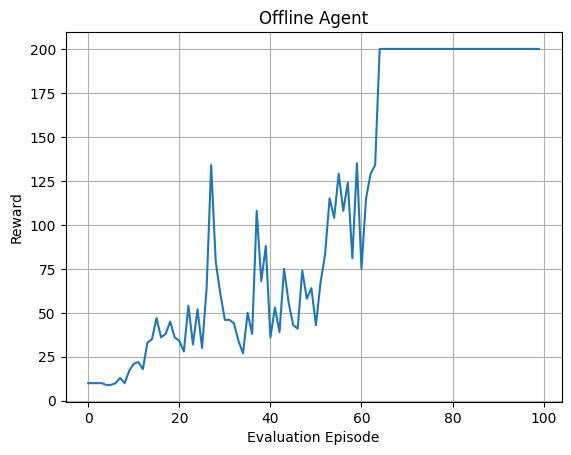

In [ ]:
plt.plot(epochs_reward)
plt.title('Offline Agent')
plt.xlabel('Evaluation Episode')
plt.ylabel('Reward')
plt.grid()

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

rewards = 0
state = env.reset()
for _ in range(200):
    frames.append(env.render()[0])
    action = offline_agent.get_next_action(state, evaluation_episode=False)
    state, reward, done, info = env.step(action)
    rewards += reward
    if done:
        break
env.close()
print(f'Reward: {rewards}')
imageio.mimsave('./offline.mp4', frames, fps=25)
show_video('./offline.mp4')

Reward: 200.0


 # Behavioural Cloning (20 points)

Behavioral cloning works by mimicking expert behavior through supervised learning. It involves collecting a dataset of expert trajectories, which are sequences of state-action pairs (unlike offline reinforcement learning, which also collects rewards to train the model). The model is then trained to predict the expert's actions based on the observed states. The goal is for the model to replicate the expert's behavior by minimizing the difference between its predicted actions and the expert's actions.

We first need to collect data using the previously trained model.

In [ ]:
env = gym.make('CartPole-v1')
num_episodes = 50000
expert_data = []

# TODO
# Collect state-action pairs
state = env.reset()
for episode in tqdm(range(num_episodes)):
    action = online_agent.get_next_action(state, evaluation_episode=True)
    expert_data.append((state, [abs(action-1), action]))
    next_state, _, _, _ = env.step(action)
    state = next_state
    if done:
        state = env.reset()

100%|██████████| 50000/50000 [00:10<00:00, 4599.19it/s]


Define the model for behaviuoral cloning.

In [ ]:
class BCModel(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(BCModel, self).__init__()
        # TODO
        # Define the model
        self.layer_stack_1 = nn.Sequential(
        nn.Linear(in_features=input_dimension, out_features=hidden_dimension),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dimension, out_features=hidden_dimension),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dimension, out_features=output_dimension)
        )

    def forward(self, x):
        # TODO
        # Perform forward pass
        return self.layer_stack_1(x)

In this section, we implement the training loop for behavioral cloning. During each iteration, we sample a minibatch of state-action pairs from the expert dataset. This minibatch is then used to update the model.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action = self.data[idx]
        return torch.tensor(state, dtype=torch.float32), torch.tensor(action, dtype=torch.float32)

In [ ]:
bc_model = BCModel(input_dimension=online_agent.state_dim, hidden_dimension=64,
                   output_dimension=online_agent.action_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(bc_model.parameters(), lr=1e-3)

num_epochs = 100
batch_size = 64
report_per_epoch = 9

dataset = CustomDataset(expert_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    # TODO
    # Implement behavioural cloning training loop
    for inputs, targets in dataloader:

            optimizer.zero_grad()
            outputs = bc_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
    if epoch % report_per_epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')

  1%|          | 1/100 [00:01<03:03,  1.85s/it]

Epoch 1/100, Loss: 94.22320571169257


 10%|█         | 10/100 [00:19<03:01,  2.01s/it]

Epoch 10/100, Loss: 12.86422097554896


 19%|█▉        | 19/100 [00:36<02:36,  1.93s/it]

Epoch 19/100, Loss: 8.71706539450679


 28%|██▊       | 28/100 [00:54<02:14,  1.87s/it]

Epoch 28/100, Loss: 7.036651519039879


 37%|███▋      | 37/100 [01:12<02:06,  2.00s/it]

Epoch 37/100, Loss: 5.793344061457901


 46%|████▌     | 46/100 [01:29<01:43,  1.92s/it]

Epoch 46/100, Loss: 4.606624810417998


 55%|█████▌    | 55/100 [01:47<01:33,  2.08s/it]

Epoch 55/100, Loss: 4.6545833532291


 64%|██████▍   | 64/100 [02:05<01:09,  1.93s/it]

Epoch 64/100, Loss: 4.118530860343526


 73%|███████▎  | 73/100 [02:23<00:58,  2.18s/it]

Epoch 73/100, Loss: 3.865409754043867


 82%|████████▏ | 82/100 [02:41<00:35,  1.98s/it]

Epoch 82/100, Loss: 3.853274070842417


 91%|█████████ | 91/100 [02:59<00:17,  1.99s/it]

Epoch 91/100, Loss: 3.336761149454105


100%|██████████| 100/100 [03:17<00:00,  1.98s/it]

Epoch 100/100, Loss: 3.594222946015634


Evaluate and render the results.

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
rewards = 0
for _ in range(300):
    frames.append(env.render()[0])
    state = torch.tensor(state).unsqueeze(0)
    action = torch.argmax(torch.softmax(bc_model(state),dim=1)) # TODO
    state, reward, done, info = env.step(action.numpy())
    rewards += reward
    if done:
        break
print(f"Reward:{rewards}")
env.close()
imageio.mimsave('./bc.mp4', frames, fps=25)
show_video('./bc.mp4')

Reward:300.0
